In [50]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from scipy.stats import randint as sp_randint
from sklearn.linear_model import SGDClassifier
from imblearn.combine import SMOTETomek
from collections import Counter

# Multiprocesado
import multiprocessing

# Guardar Modelo
import pickle

# DATOS PAPER

In [51]:
path = "EMG_6_dataset.csv"

df = pd.read_csv(path)

In [52]:
np.random.seed(33)

## Análisis exploratorio de los datos EDA

Para poder entender y comprender los datos con los que vamos a trabajar debemos saber:
- Cuántas instancias y atributos hay.
- Qué tipo de atributos hay.
- Si faltan atributos.

In [53]:
df.head()

,Sample_num,Task_number,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,Timestamp,Video_timestamp,Angle_sample,Subject
0,0,0,17031,2762,3782,6898,-9152,-198,3669,-35714,1635432201,1635432201,0,0
1,1,0,17020,2751,3773,6894,-9166,-192,3649,-35719,1635432201,1635432201,0,0
2,2,0,17007,2736,3761,6891,-9154,-172,3652,-35736,1635432201,1635432201,0,0
3,3,0,17003,2729,3752,6880,-9155,-182,3661,-35729,1635432201,1635432201,0,0
4,4,0,17029,2748,3773,6896,-9147,-207,3667,-35709,1635432201,1635432201,0,0


In [54]:
print(df.shape)

(195063, 14)


Obtenemos el número de gestos realizados, `label`

In [55]:
print("Gestos :", len(df["Task_number"].unique()))
print()

Gestos : 8



0. Reposo 
1. Flexión de pulgar
2. Flexión del índice
3. Flexión del dedo corazón 
4. Flexión del anular 
5. Flexión del meñique 
6. Extensión de muñeca 
7. Flexión de muñeca


Observamos que tipos de datos tenemos en cada columna de la base de datos

In [56]:
df.dtypes

Sample_num         int64
Task_number        int64
EMG1               int64
EMG2               int64
EMG3               int64
EMG4               int64
EMG5               int64
EMG6               int64
EMG7               int64
EMG8               int64
Timestamp          int64
Video_timestamp    int64
Angle_sample       int64
Subject            int64
dtype: object

Dividimos los datos en entrados y salidas, de la entrada eliminamos datos irrelevantes para el cálculo de la salida, en este caso el momento exacto, `TimeStamp`, en el que lo realiza y la propia salida, `label`.

In [57]:
X_df = df.drop(["Task_number", "Sample_num", "Timestamp", "Video_timestamp", "Angle_sample", "Subject"], axis=1)
y_df = df["Task_number"]

In [9]:
X_df.head()

,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8
0,17031,2762,3782,6898,-9152,-198,3669,-35714
1,17020,2751,3773,6894,-9166,-192,3649,-35719
2,17007,2736,3761,6891,-9154,-172,3652,-35736
3,17003,2729,3752,6880,-9155,-182,3661,-35729
4,17029,2748,3773,6896,-9147,-207,3667,-35709


In [10]:
y_df.head()

0    0
1    0
2    0
3    0
4    0
Name: Task_number, dtype: int64

In [11]:
X_df.describe()

,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8
count,1.950630e+05,1.950630e+05,1.950630e+05,1.950630e+05,1.950630e+05,1.950630e+05,1.950630e+05,1.950630e+05
mean,2.037369e+05,2.101022e+05,2.628609e+05,2.001331e+05,2.371797e+05,3.001526e+05,2.159257e+04,-3.246947e+05
std,1.328529e+05,1.314076e+05,2.041662e+05,1.497988e+05,1.639150e+05,2.032041e+05,4.754670e+04,1.553540e+05
min,-3.539094e+06,-4.456437e+06,-5.111793e+06,-6.815789e+06,-2.809344e+06,-3.753000e+04,-4.980781e+06,-4.543850e+05
25%,1.267145e+05,1.724305e+05,8.792350e+04,1.428505e+05,1.665785e+05,2.270830e+05,8.514000e+03,-4.305715e+05
50%,1.829380e+05,2.020860e+05,2.522190e+05,1.852760e+05,2.680180e+05,3.234540e+05,1.290900e+04,-4.003560e+05
75%,3.500580e+05,3.336395e+05,4.681440e+05,2.352280e+05,3.086525e+05,3.800675e+05,3.701300e+04,-3.384275e+05
max,7.073280e+06,1.038336e+06,3.510272e+06,1.056511e+06,8.126487e+06,6.750222e+06,4.718444e+06,3.997696e+06


Observamos si las salidas estan balanceadas

In [12]:
y_df.value_counts()

Task_number
0    145003
4      8324
1      8031
7      7513
5      7171
6      6580
3      6484
2      5957
Name: count, dtype: int64

Observamos si hay valores nulos

In [13]:
X_df.isnull().any()

EMG1    False
EMG2    False
EMG3    False
EMG4    False
EMG5    False
EMG6    False
EMG7    False
EMG8    False
dtype: bool

In [14]:
X_df.isnull().sum()

EMG1    0
EMG2    0
EMG3    0
EMG4    0
EMG5    0
EMG6    0
EMG7    0
EMG8    0
dtype: int64

In [15]:
X_df.isnull().sum() / len(X_df) * 100

EMG1    0.0
EMG2    0.0
EMG3    0.0
EMG4    0.0
EMG5    0.0
EMG6    0.0
EMG7    0.0
EMG8    0.0
dtype: float64

In [16]:
y_df.isnull().any()

False

In [17]:
y_df.isnull().sum()

0

In [18]:
y_df.isnull().sum() / len(y_df) * 100

0.0

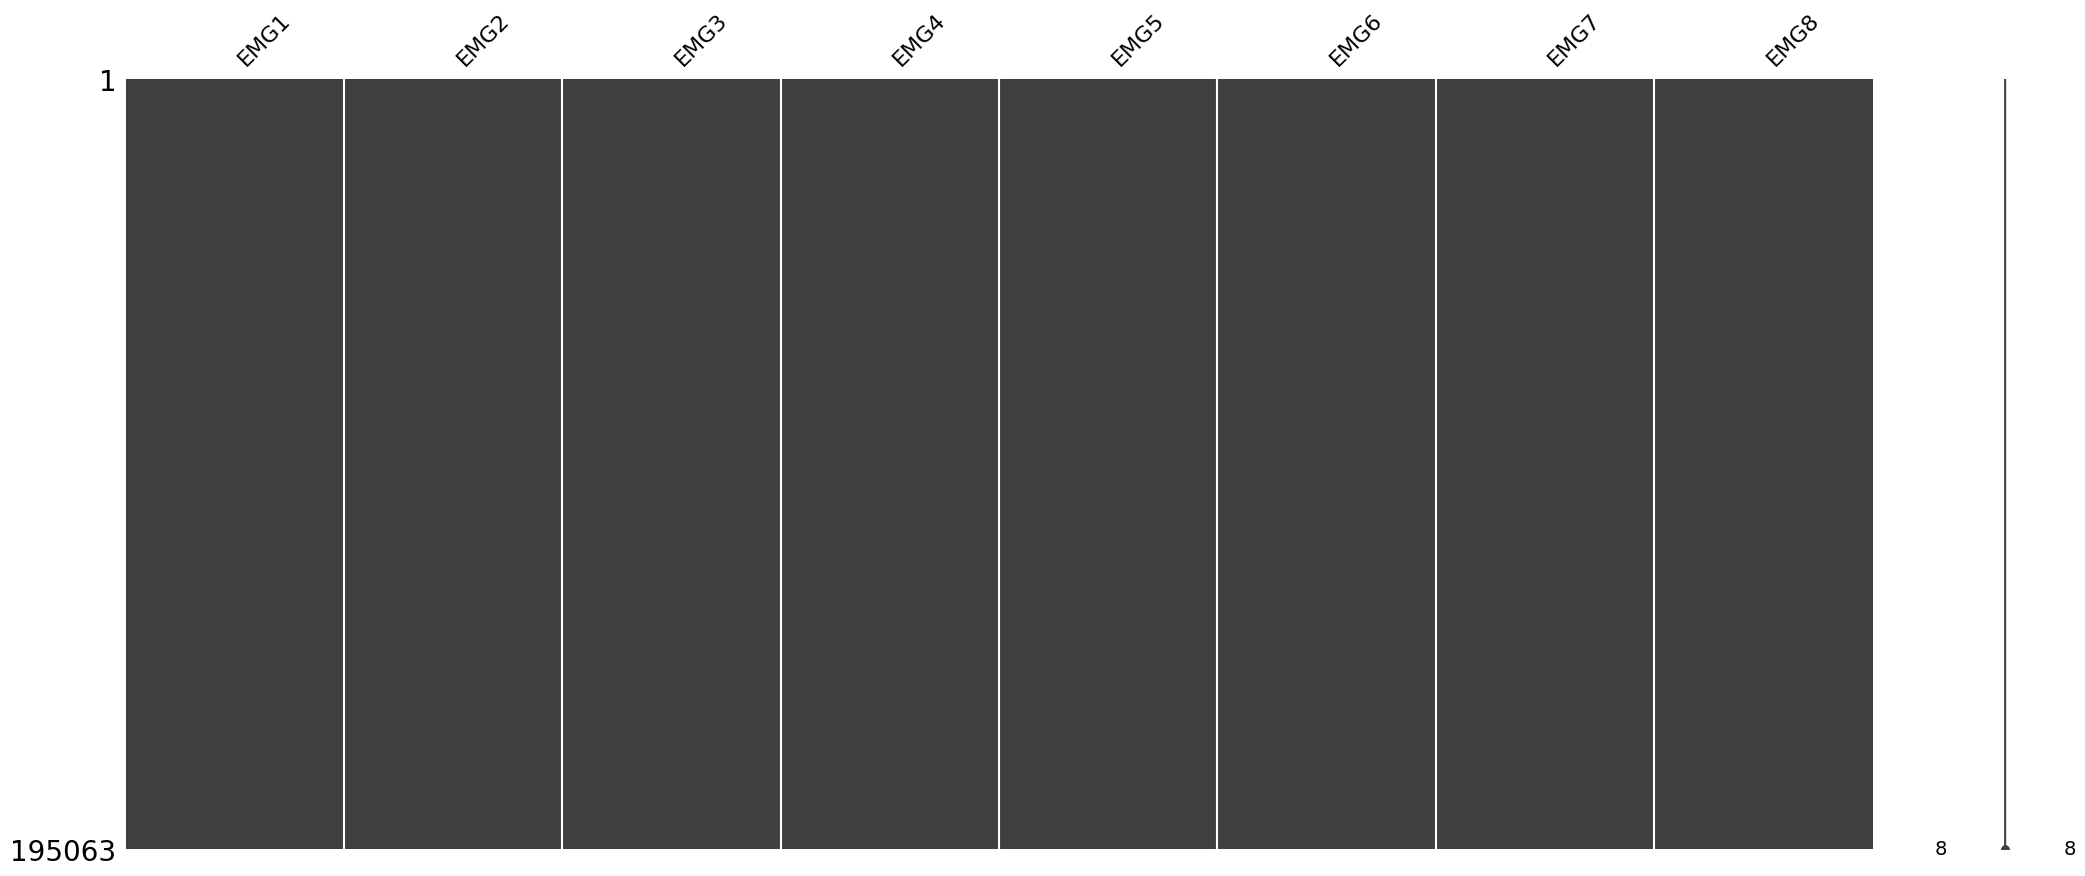

In [19]:
%config InlineBackend.figure_format = 'png'

msno.matrix(X_df)
plt.show()

Obtenemos la matriz de correlación entre las variables y la salida

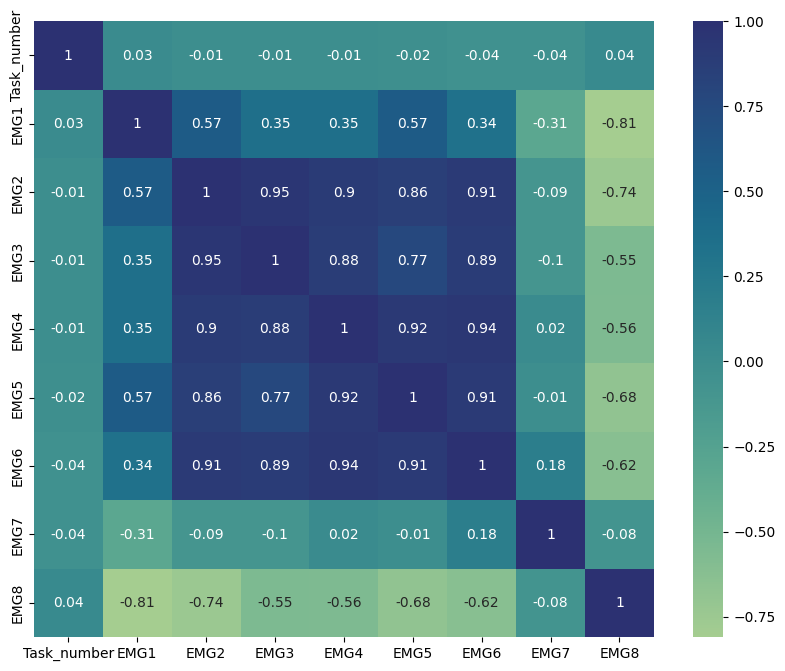

In [20]:
aux_df = df.drop(["Sample_num", "Timestamp", "Video_timestamp", "Angle_sample", "Subject"], axis=1)

plt.figure(figsize=(10, 8))

matriz_correlacion = aux_df.corr().round(2)
sns.heatmap(data=matriz_correlacion, annot=True, cmap="crest")

plt.show()

## PREPROCESADOR

Dividimos los datos en entrenamiento y test

In [58]:
os_us = SMOTETomek(random_state=33)
X_df, y_df = os_us.fit_resample(X_df, y_df)

In [61]:
x_train, x_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=33, shuffle=True)

In [62]:
y_train.value_counts()

Task_number
4    101733
1    101624
0    101579
7    101564
6    101472
5    101456
3    101352
2    101190
Name: count, dtype: int64

In [24]:
num_cols = x_train.select_dtypes(exclude="object").columns

1. Realizamos un `MinMaxScaler` para transformar los datos para que se encuentren dentro de un rango entre 0 y 1.
2. Realizamos un `RobustScaler` para escalar los datos de manera robusta frente a valores atípicos.

In [25]:
num_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('scaler2', RobustScaler())
])

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols)
    ])

In [27]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                                 ('scaler2', RobustScaler())]),
                                 Index(['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8'], dtype='object'))])

## XGBOOST

In [28]:
boost_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(random_state=33))])

In [29]:
XGBoost_dist = {'classifier__max_depth'      : [3, 5, 7, 9, 11, 13, 15, 25, 50, 75, 100],
              'classifier__subsample'        : [0.1, 0.3, 0.5, 0.7, 0.9, 1],
              'classifier__learning_rate'    : [0.1, 0.3, 0.5, 0.7, 0.9, 1],
              'classifier__n_estimators'     : sp_randint(10, 500).rvs(5)
              }

XGBoost_grid = RandomizedSearchCV(boost_pipe,
    param_distributions = XGBoost_dist,
    scoring    = 'balanced_accuracy',
    n_jobs     = multiprocessing.cpu_count() - 1,
    cv         = 3,
    refit      = True,
    verbose    = 0,
    n_iter=3
)

np.random.seed(33)

XGBoost_grid.fit(X = x_train, y = y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                MinMaxScaler()),
                                                                                               ('scaler2',
                                                                                                RobustScaler())]),
                                                                               Index(['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8'], dtype='object'))])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=...
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=33, ...))]),
                   n_iter=3, n_jobs=19,
                   param_distributions={'classifier__learning_rate': [0.1, 0.3,
                                                                      0.5, 0.7,
                                                                      0.9, 1],
                                        'classifier__max_depth': [3, 5, 7, 9,
                                                                  11, 13, 15,
                                                                  25, 50, 75,
                                                                  100],
                                        'classifier__n_estimators': array([ 30, 401, 226,  76, 156], dtype=int64),
                                        'classifier__subsample': [0.1, 0.3, 0.5,
                                                                  0.7, 0.9,
                                                                  1]},
                   scoring='balanced_accuracy')

In [41]:
resultados = pd.DataFrame(XGBoost_grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_classifier__subsample,param_classifier__n_estimators,param_classifier__max_depth,param_classifier__learning_rate,mean_test_score,std_test_score
0,0.1,156,5,0.7,0.984904,0.000397
2,0.1,226,9,1,0.983803,0.000214
1,0.3,30,7,0.3,0.976114,0.000083


In [42]:
XGBoost_grid.best_params_

{'classifier__subsample': 0.1,
 'classifier__n_estimators': 156,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.7}

In [43]:
XGBoost_grid.best_score_

0.9849040239953081

In [44]:
print(XGBoost_grid.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('scaler2',
                                                                   RobustScaler())]),
                                                  Index(['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8'], dtype='object'))])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsamp...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.7,

In [45]:
modelo_final_xgb = XGBoost_grid.best_estimator_
y_test_pred = modelo_final_xgb.predict(x_test)

In [46]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.94     43391
           1       0.99      1.00      0.99     43375
           2       0.98      1.00      0.99     43812
           3       0.98      1.00      0.99     43647
           4       0.99      1.00      0.99     43262
           5       0.99      1.00      0.99     43541
           6       0.99      1.00      0.99     43529
           7       0.99      1.00      1.00     43431

    accuracy                           0.99    347988
   macro avg       0.99      0.99      0.99    347988
weighted avg       0.99      0.99      0.99    347988



In [47]:
xgb_accuracy = accuracy_score(y_test, y_test_pred)

print(f"El valor de accuracy: {xgb_accuracy}")

El valor de accuracy: 0.9864909134797751


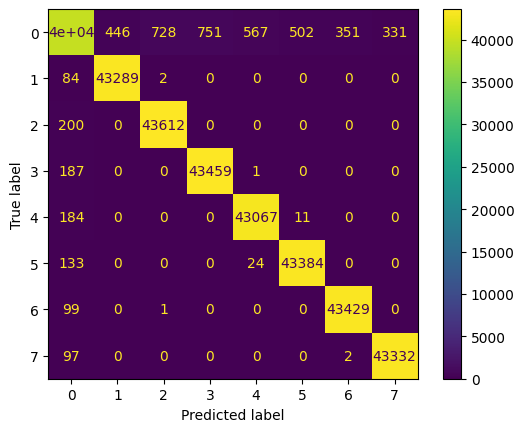

In [48]:
cm = confusion_matrix(y_test, y_test_pred, labels=XGBoost_grid.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=XGBoost_grid.classes_)
disp.plot()
plt.show()

## ELECCION DEL MEJOR MODELO

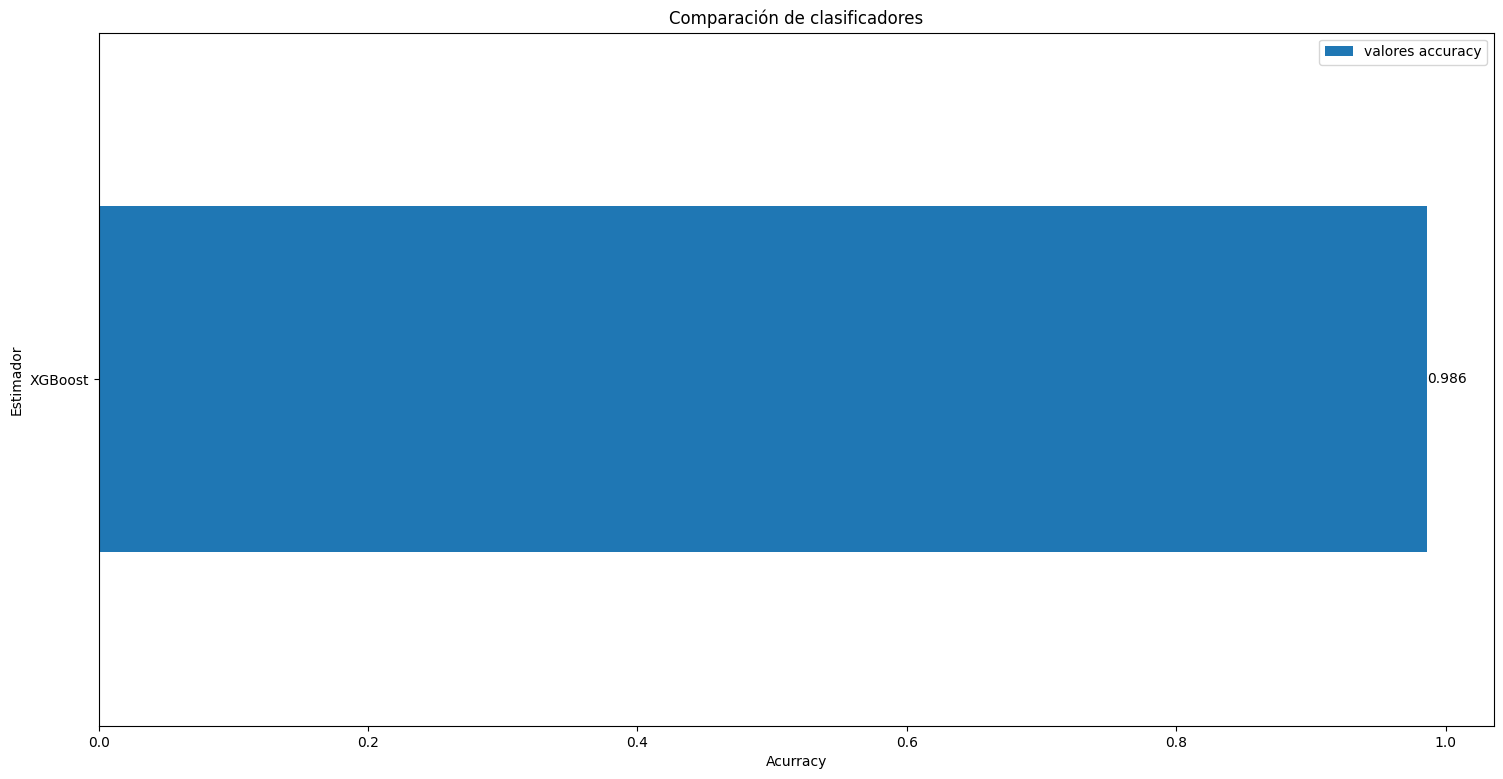

In [38]:
df_comparacion = pd.DataFrame({
                    'estimador': ['XGBoost'],
                    'valores accuracy': [xgb_accuracy]
                 })

fig, ax = plt.subplots(figsize=(18, 9))
df_comparacion.set_index('estimador').plot(kind='barh', ax=ax)
ax.set_xlabel('Acurracy')
ax.set_ylabel('Estimador')
ax.set_title('Comparación de clasificadores');

for i, v in enumerate(df_comparacion['valores accuracy']):
    ax.annotate(str(round(v, 3)), xy=(v, i), va='center', ha='left', fontsize=10)

Ahora diseñamos EL modelos para probar su capacidad de generalización, con otros datos en el archivo `test_gene.ipynb`.

In [39]:
preprocessor = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('scaler2', RobustScaler())
])

In [40]:
best_clas = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        learning_rate = 0.1,
        max_depth = 5,
        n_estimators = 436,
        subsample = 0.7        
    ))
])

pickle.dump(best_clas.fit(x_train, y_train), open('modelo_XGB.pkl', 'wb'))